In [41]:
import time
import torch
from torch.utils.data import DataLoader, Dataset
import PIL
import os
from torchvision import transforms as transforms
import torch.optim as optim
import torchvision.models as models
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
import seaborn as sns
import sys
sys.path.append('../')
from utils import MHCoverDataset, get_dataloader

In [9]:
df = pd.read_csv("../data/transformation_split.csv")
df = df.drop_duplicates()

In [10]:
len(df.label.unique())

13

In [11]:
train_df = df.loc[df['set'] == "train"]
test_df = df.loc[df['set'] == "test"]
val_df = df.loc[df['set'] == "val"]

In [12]:
path = "../data/prepared_images"

In [13]:
def get_transform():
    return transforms.Compose([transforms.ToTensor()])

In [14]:
trainloader = get_dataloader(root_dir = path, df= train_df, transformations = get_transform(),batch_size=16,workers=0)
valloader = get_dataloader(root_dir = path, df= val_df, transformations = get_transform(),batch_size=16,workers=0)
testloader = get_dataloader(root_dir = path, df= test_df, transformations = get_transform(),batch_size=16,workers=0)

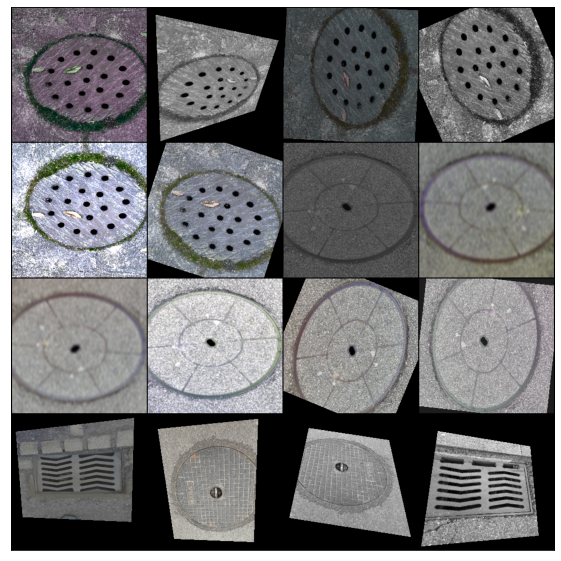

In [15]:
# Visualize one training batch
for images, labels in trainloader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(59536, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 13)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [18]:
def train(model, iterator, optimizer, criterion, device, regularizer = None):
    
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()    
        y_pred = model(x)
        loss = criterion(y_pred, y)
        
        if regularizer == "L1":
            l1_l_c = nn.L1Loss()
            l1_lambda = 0.01
            l1_norm = 0
            for parameter in model.parameters():
                l1_norm += l1_l_c(parameter,target=torch.zeros_like(parameter))
            l1 = l1_lambda * l1_norm
            # Add L1 loss component
            loss += l1
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
def evaluate(model, iterator, criterion, device, regularizer = None):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)
            if regularizer == "L1":
                l1_l_c = nn.L1Loss()
                l1_lambda = 0.01
                l1_norm = 0
                for parameter in model.parameters():
                    l1_norm += l1_l_c(parameter,target=torch.zeros_like(parameter))
                l1 = l1_lambda * l1_norm
                # Add L1 loss component
                loss += l1

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [20]:
def epoch_time(start, end):
    elapsed_time = end - start
    elapsed_in_min = int(elapsed_time / 60)
    elapsed_in_sec = int(elapsed_time - (elapsed_in_min * 60))
    return elapsed_in_min, elapsed_in_sec

In [21]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    accuracy = correct.float() / y.shape[0]
    return accuracy

In [22]:
def train_epoch(epochs, model, trainloader, optimizer, criterion, device, regularizer = None):
   
    train_losses = []
    train_accuracy = []
    valid_losses = []
    valid_accuracy = []
    best_valid_loss = float('inf')
    for epoch in range(epochs):
        
        start_time = time.monotonic()

        train_loss, train_acc = train(model, trainloader, optimizer, criterion, device, regularizer = regularizer)
        valid_loss, valid_acc = evaluate(model, valloader, criterion, device, regularizer = regularizer)

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        train_losses.append(train_loss)
        train_accuracy.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accuracy.append(valid_acc)
        
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s || Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% || Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    return model, train_losses, train_accuracy, valid_losses, valid_accuracy

In [23]:
def metric_evaluation(y_test, y_pred):
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    fig = plt.subplots(figsize=(20, 5))
    plt.subplot(1,2,1)
    p1 = sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=classes,yticklabels=classes, cmap="YlGnBu")
    p1.set_title('Confusion Matrix')
    p1.set_ylabel('True')
    p1.set_xlabel('Predicted')

    plt.subplot(1,2,2)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    metric_names = ['Recall Macro', 'Precision Macro', 'F1 Macro']
    metrics = [recall, precision, f1]

    p2 = sns.barplot(x=metric_names, y=metrics,palette="Blues_d")
    for i, value in enumerate(metrics):
        plt.text(x=i, y=value, s=str(round(value,3)), ha='center')
    p2.set_ylim(0,1) 
    p2.set_title('metrics')
    p2.set_ylabel('Score')
    sns.despine()

    plt.show()

In [24]:
def get_predictions(model, iterator, device):
    
    model.eval()
    images = []
    labels = []
    probs = []
    
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred = model(x)
            
            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [25]:
def loss_acc_function(train_loss,valid_loss,train_acc,valid_acc):
    
    fig = plt.subplots(figsize=(15, 5))
    plt.subplot(1,2,1)
    plt.plot(train_loss, label='Training loss')
    plt.plot(valid_loss, label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(frameon=False)
    
    plt.subplot(1,2,2)
    plt.plot(train_acc, label='Training accuracy')
    plt.plot(valid_acc, label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(frameon=False)
    plt.show()

In [26]:
batch_size = 32
epochs = 10
num_workers = 0
learning_rate = 0.001


trainloader = get_dataloader(root_dir = path, df= train_df, transformations = get_transform(),batch_size=batch_size,workers=num_workers)
valloader = get_dataloader(root_dir = path, df= val_df, transformations = get_transform(),batch_size=batch_size,workers=num_workers)
testloader = get_dataloader(root_dir = path, df= test_df, transformations = get_transform(),batch_size=batch_size,workers=num_workers)

model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [27]:
model, train_losses, train_accuracy, valid_losses, valid_accuracy = train_epoch(epochs, model, trainloader, optimizer, criterion, device)

Epoch: 01 | Epoch Time: 0m 45s || Train Loss: 2.571 | Train Acc: 6.42% || Val. Loss: 2.553 |  Val. Acc: 8.48%
Epoch: 02 | Epoch Time: 0m 42s || Train Loss: 2.566 | Train Acc: 7.56% || Val. Loss: 2.556 |  Val. Acc: 8.04%
Epoch: 03 | Epoch Time: 0m 41s || Train Loss: 2.553 | Train Acc: 12.50% || Val. Loss: 2.600 |  Val. Acc: 16.96%
Epoch: 04 | Epoch Time: 0m 43s || Train Loss: 2.457 | Train Acc: 11.51% || Val. Loss: 3.221 |  Val. Acc: 10.27%
Epoch: 05 | Epoch Time: 0m 41s || Train Loss: 2.294 | Train Acc: 15.33% || Val. Loss: 3.769 |  Val. Acc: 11.16%
Epoch: 06 | Epoch Time: 0m 42s || Train Loss: 2.200 | Train Acc: 16.72% || Val. Loss: 4.876 |  Val. Acc: 2.68%
Epoch: 07 | Epoch Time: 0m 42s || Train Loss: 2.148 | Train Acc: 18.11% || Val. Loss: 4.772 |  Val. Acc: 2.68%
Epoch: 08 | Epoch Time: 0m 42s || Train Loss: 2.108 | Train Acc: 20.00% || Val. Loss: 5.280 |  Val. Acc: 2.68%
Epoch: 09 | Epoch Time: 0m 42s || Train Loss: 2.067 | Train Acc: 22.70% || Val. Loss: 5.525 |  Val. Acc: 2.23%


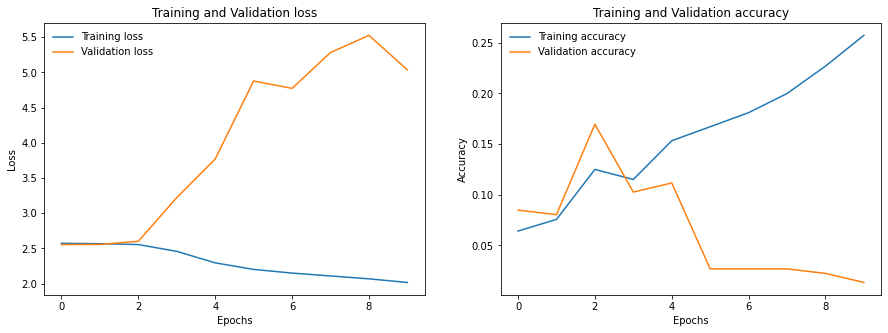

In [28]:
loss_acc_function(train_losses,valid_losses,train_accuracy,valid_accuracy)

In [31]:
test_loss, test_acc = evaluate(model, testloader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 4.867 | Test Acc: 0.79%


In [37]:
images, labels, probs = get_predictions(model, testloader, device)
pred_labels = torch.argmax(probs, 1)
f1_SGD_32ba_20ep_001lr = f1_score(labels, pred_labels, average='macro', zero_division=0)

In [45]:
classes = list(df.label.unique())

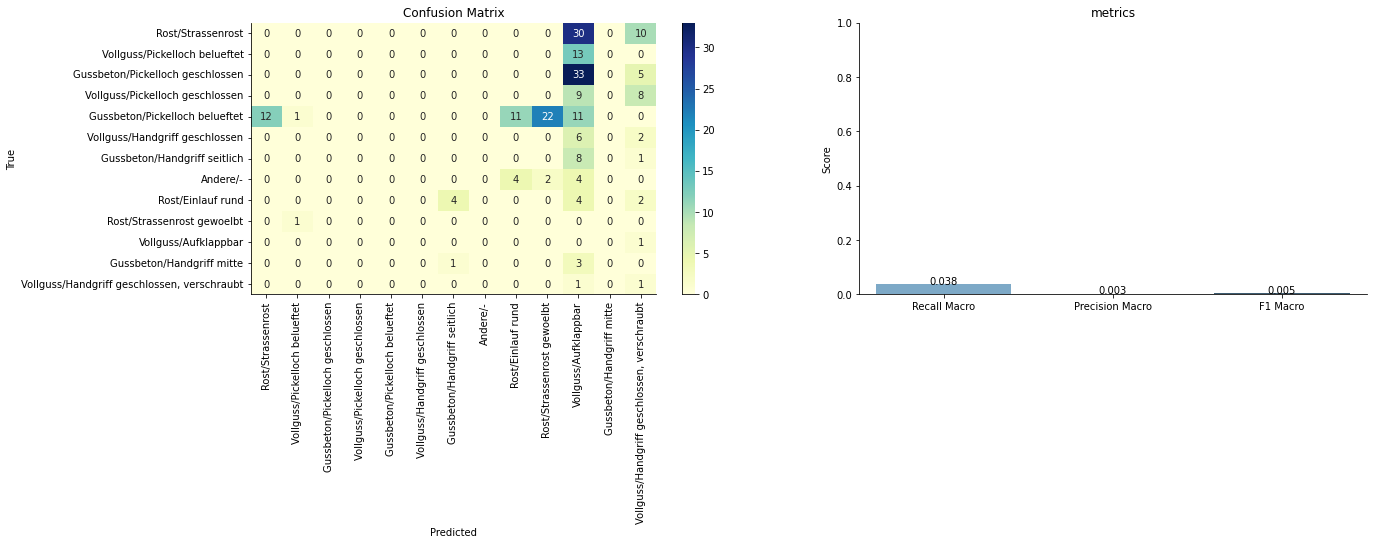

In [46]:
metric_evaluation(labels, pred_labels)

Beobachtung:

Model isch ja mal richtig kacke xD